In [ ]:
!gdown "https://drive.google.com/uc?id=14u7fkARS8WRJUdhvU79kDxg8EKTqg606"
!gdown "https://drive.google.com/uc?id=1--tADAa10l2M1iaSEslGXK-RaBv8UbMf"

Downloading...
From: https://drive.google.com/uc?id=14u7fkARS8WRJUdhvU79kDxg8EKTqg606
To: /content/data_train.npz
1.72GB [00:18, 94.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--tADAa10l2M1iaSEslGXK-RaBv8UbMf
To: /content/labels_train.npz
7.16MB [00:00, 63.3MB/s]


Let's install some package that'll make our job easier :

In [ ]:
!pip install segmentation-models-pytorch==0.1.2  # easy to use some famous model architecture. visit https://github.com/qubvel/segmentation_models.pytorch/
!pip install albumentations               # easy image manipulation for data augmentation

     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 163kB 36.5MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=15ecf5d77b10b7173e744ea8e29e484fd320dd124df60adf1fb7da5e67054433
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=d62b69be61ee765ae545f905231aa4a6576329cedad28cb4234bf47486d6586b
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch
     |████████████████████████████████| 634kB 16.2MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=2bd0fd1798120cc3cc19e0c808f3723d34695735e6d8b8883223305a26ebfe2f
  Store

Import the packages :

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
import albumentations as A
import os
from ipywidgets import IntProgress
from IPython.display import display
import time
import cv2
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Load the data and see the shape:

In [ ]:
train_data_full = np.load('data_train.npz', allow_pickle=True, mmap_mode='r')['data']
train_label_full = np.load('labels_train.npz', allow_pickle=True, mmap_mode='r')['labels']

In [ ]:
print('shape            :',train_data_full.shape)
print('min-max amplitude:',train_data_full.min(),'&',train_data_full.max())

shape            : (1006, 782, 590)
min-max amplitude: -5195.5234 & 5151.7188


If you see the [EDA by sergeytsimfer](https://discourse.aicrowd.com/t/explainer-eda-in-details-baseline-and-advanced-models/3745), especially the amplitude distribution, you can improve your score by doing quantile to the data or for me **gain+rms** is what perform the best.

You can also add it to extra channel (so the dimension will be vanilla+processed,size x, size y) but for me the improvement is really small and not worth the extra computation time.

In [ ]:
import math
from scipy.signal.windows import triang
from scipy.signal import convolve2d as conv2
def gain(data,dt,parameters):
    nt,nx = data.shape
    dout = np.zeros(data.shape)
    L = parameters/dt+1
    L = np.floor(L/2)
    h = triang(2*L+1)
    shaped_h  = h.reshape(len(h),1)
    for k in range(nx):
        aux = data[:,k]
        e = aux**2
        shaped_e = e.reshape(len(e),1)
        rms = np.sqrt(conv2(shaped_e,shaped_h,"same"))
        epsi = 1e-10*max(rms)
        op = rms/(rms**2+epsi)
        op = op.reshape(len(op),)
        dout[:,k] = data[:,k]*op
    for k in range(nx):
        aux = dout[:,k]
        amax = np.sqrt(sum(aux**2)/nt)
        dout[:,k] = dout[:,k]/amax
    return dout 

Let's test it for one slice :

In [ ]:
test_proc=train_data_full[:,0,:]
dat_proc=gain(test_proc,3e-3,0.8)

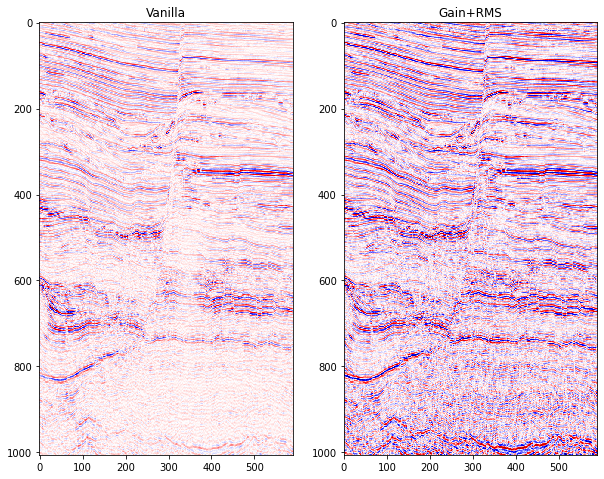

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,8))
ax[0].imshow(test_proc,interpolation='none',cmap='seismic')
ax[1].imshow(dat_proc,interpolation='none',cmap='seismic')

ax[0].set_title("Vanilla")
ax[1].set_title("Gain+RMS")
plt.show()

Now you can run these to process all the data, but it'll take some time to finish!

In [ ]:
print('preprocessing the data :')
f = IntProgress(min=0, max=train_data_full.shape[1])
display(f)
for i in range(0,train_data_full.shape[1]):
    #print('reprocess : ',i+1,'of',train_data_full.shape[1])
    train_data_full[:,i,:]=gain(train_data_full[:,i,:],3e-3,0.8)
    f.value += 1

IntProgress(value=0, max=782)

if you don't want to wait, then you can use this instead.

In [ ]:
!gdown "https://drive.google.com/uc?id=1JZ5LZz_f2Vfg9BxuGGBY9LliJQAAHi_H"
train_data_full=np.load('data_train_processed.npz')['data']

Downloading...
From: https://drive.google.com/uc?id=1JZ5LZz_f2Vfg9BxuGGBY9LliJQAAHi_H
To: /content/data_train_processed.npz
1.73GB [00:13, 132MB/s] 


then we rescale the data :

In [ ]:
train_data_full = (train_data_full - train_data_full.min()) / (train_data_full.max() - train_data_full.min())

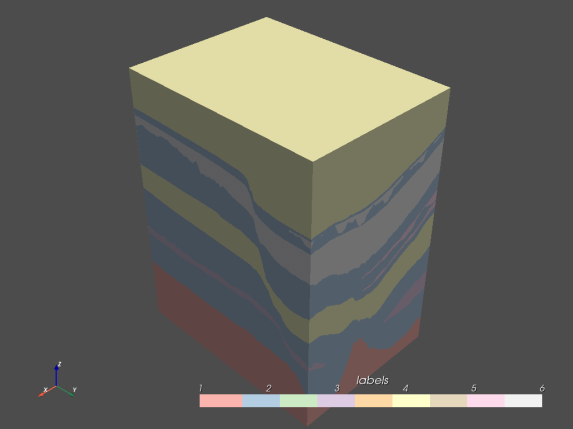

And let's see the label distribution :

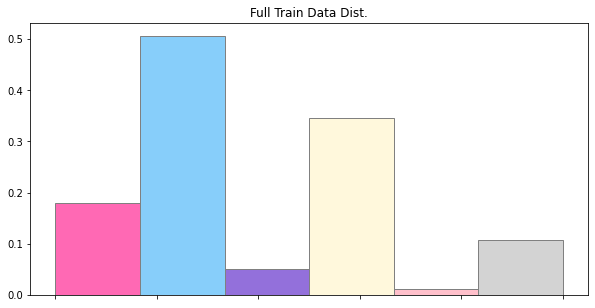

In [ ]:
fig = plt.figure(figsize=(10,5))
labels    = ["1", "2", "3", "4", "5", "6"]
colors = ['hotpink', 'lightskyblue', 'mediumpurple','cornsilk', 'pink', 'lightgrey']
N, bins, patches = plt.hist(train_label_full.flatten(),6,density=True, edgecolor='gray', linewidth=1)
for i in range(6):
    patches[i].set_facecolor(colors[i])
    patches[i].set_label(labels[i])
plt.gca().axes.xaxis.set_ticklabels([])
plt.title('Full Train Data Dist.')
plt.show()

Now, about the test cube, it's better to pick the part that also got the label-5.

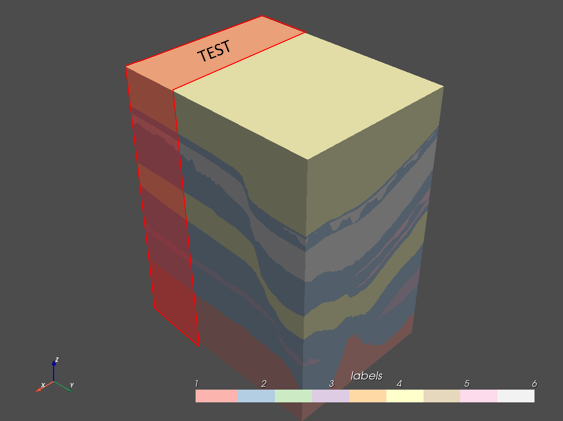

Don't do this :

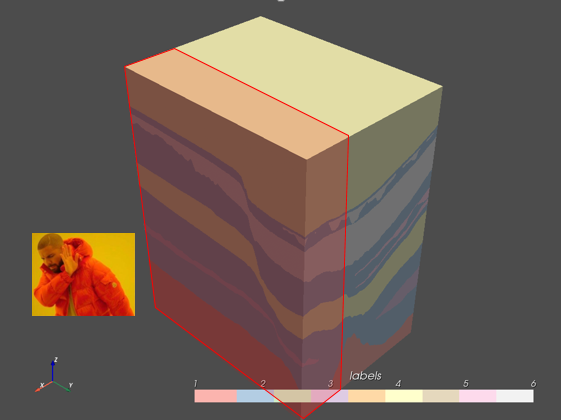

As you can see, if we pick this area as a test, then no label-5 that'll be represented.

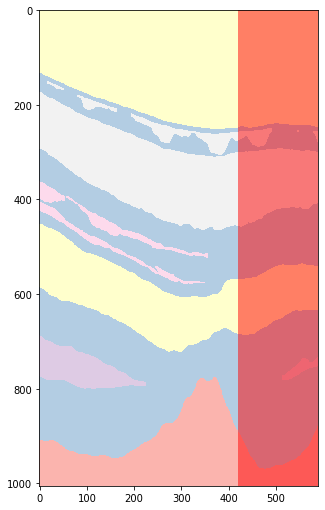

In [ ]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(5,10))
im = ax.imshow(train_label_full[:,-1,:],interpolation='none',cmap='Pastel1')
rect = plt.Rectangle((420,0),300,1500,facecolor='red',alpha=0.5)
ax.add_patch(rect)
plt.show()

Now let's split the train and test data :

In [ ]:
split_sample = 0.7
test_data = train_data_full[:,:train_data_full.shape[1]-int(train_data_full.shape[1]*split_sample),:]
train_data = train_data_full[:,train_data_full.shape[1]-int(train_data_full.shape[1]*split_sample):,:]
test_label = train_label_full[:,:train_label_full.shape[1]-int(train_label_full.shape[1]*split_sample),:]
train_label = train_label_full[:,train_label_full.shape[1]-int(train_label_full.shape[1]*split_sample):,:]

In [ ]:
print('train cube shape :',train_data.shape)
print('test cube shape :',test_data.shape)

train cube shape : (1006, 547, 590)
test cube shape : (1006, 235, 590)


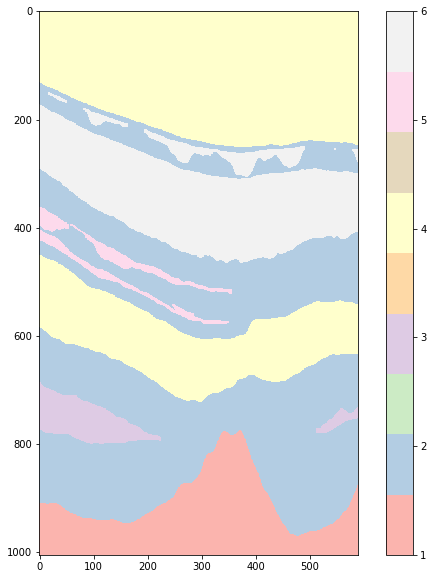

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.imshow(train_label[:,-1,:],interpolation='none',cmap='Pastel1')
plt.colorbar()
plt.show()

and see the label distribution :

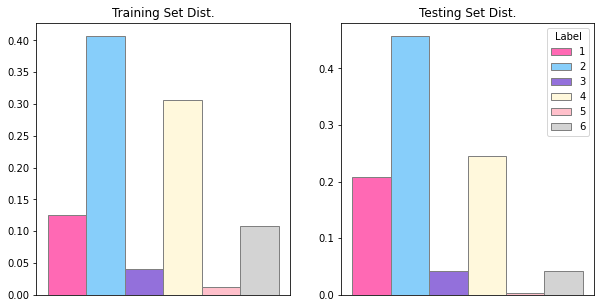

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
labels    = ["1", "2", "3", "4", "5", "6"]
colors = ['hotpink', 'lightskyblue', 'mediumpurple','cornsilk', 'pink', 'lightgrey']
N, bins, patches = ax[0].hist(train_label.flatten(),[1, 2, 3, 4, 5, 6, 7],density=True, edgecolor='gray', linewidth=1)
for i in range(6):
    patches[i].set_facecolor(colors[i])
N2, bins2, patches2 = ax[1].hist(test_label.flatten(),[1, 2, 3, 4, 5, 6, 7],density=True, edgecolor='gray', linewidth=1)
for i in range(6):
    patches2[i].set_facecolor(colors[i])
    patches2[i].set_label(labels[i])
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[0].set_title("Training Set Dist.")
ax[1].set_title("Testing Set Dist.")
plt.legend(title="Label")
plt.show()

Yikes, that's still quite an imbalance that we got here.



In [ ]:
print('label 5 count of train data : ',np.count_nonzero(train_label.flatten() == 5))
print('label 5 count of test data : ',np.count_nonzero(test_label.flatten() == 5))

label 5 count of train data :  4190167
label 5 count of test data :  428833


Still it's not empty if we splice it the other way.

#Setting up the Model, Hyperparameter, Dataloader, etc.

Let's set up some stuff for training the models.

First, the metric that we will use from Aicrowd.

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score,accuracy_score  #for score metric calculation
def _prf_divide(numerator, denominator, ):
    """Performs division and handles divide-by-zero.
    On zero-division, sets the corresponding result elements equal to
    0 or 1 (according to ``zero_division``). 
    """
    mask = denominator == 0.0
    denominator = denominator.copy()
    denominator[mask] = 1  # avoid infs/nans
    result = numerator / denominator

    return result

def compute_scores(y_true, y_pred, class_weights=[1, 1, 1, 1, 20, 20]):
    """
    Computes the weighted & unweighted f1_score and accuracy
    Using the standard F1-Score and class-wise accuracy computations were quite 
    slow as we were doing a lot of redundant work across all score computations,
    hence we have implemented this from the base principles.
    Please refer to the inline comments.
    """

    # Initial Housekeeping Taks1
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    class_weights = np.array(class_weights)
    # print(np.max(y_true))
    # print(np.max(y_pred))
    # print(np.min(y_true))
    # print(np.min(y_pred))
    # Computing Multilabel Confusion Matrix
    #print("--------- Computing MCM... ")
    #begin_time = time.time()
    MCM = multilabel_confusion_matrix(y_true, y_pred,labels=[1,2,3,4,5,6])
    #print("MCM computation time  : ", time.time() - begin_time)
    
    """
    Gather True Positives, True Negatives, False Positives, False Negatives
    """
    tp_sum = MCM[:, 1, 1]
    tn_sum = MCM[:, 0, 0]
    fn_sum = MCM[:, 1, 0]
    fp_sum = MCM[:, 0, 1]
    
    #print("--------- Computing per class instances... ")
    per_class_instances = np.bincount(y_true) # Helps keep a track of total number of instances per class
    per_class_instances = per_class_instances[1:] # as the class names in the dataset are NOT zero-indexed
    
    assert class_weights.shape == per_class_instances.shape
    
    #print("--------- Computing precision... ")
    # precision : tp / (tp + fp)
    precision = _prf_divide(
                    tp_sum,
                    (tp_sum + fp_sum)
                )
    #print("--------- Computing recall... ")                        
    # recall : tp / (tp + fn)
    recall = _prf_divide(
                    tp_sum,
                    (tp_sum + fn_sum)
                )

    #print("--------- Computing F1 score... ")
    # f1 : 2 * (recall * precision) / (recall + precision)
    f1_score = _prf_divide(
                    2 * precision * recall,
                    precision + recall
                )
    #print("--------- Computing Accuracy... ")
    # accuracy = tp_sum / instances_per_class
    # NOTE: we are computing the accuracy independently for all the class specific subgroups
    # accuracy = _prf_divide(
    #                 tp_sum,
    #                 per_class_instances
    #             )
    # print(class_weights)
    # print(f1_score)
    f1_score_weighted = np.dot(class_weights, f1_score) / np.sum(class_weights)
    f1_score_unweighted = f1_score.mean()

    # accuracy_weighted = np.dot(class_weights, accuracy) / np.sum(class_weights)
    # accuracy_unweighted = accuracy.mean()

    return f1_score_weighted, f1_score_unweighted#, accuracy_weighted, f1_score_unweighted, accuracy_unweighted



Then the training parameters:

In [ ]:
batch_size = 8      
num_epochs = 40      
num_classes = 6       
learning_rate = 0.00085 

Set up the architecture, pretty simple using `smp`, right?

Also we don't use pretrained weight here. (After some experiment, pretrained weight got worse score).

In [ ]:
model = smp.PSPNet(
    encoder_name="efficientnet-b3",        
    encoder_weights=None,     
    in_channels=1,                  
    classes=num_classes,                    
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("")

Now let's put some random value to test if it works:

In [ ]:
test = torch.rand(1, 1, 320, 320).cuda()
out = model(test)
out.shape

torch.Size([1, 6, 320, 320])

And set up the optimizer and loss function:

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

Next, let's make the train dataloader:

In [ ]:
class seisdataset_train(Dataset):
    def __init__(self, x_set, y_set):
        self.x, self.y = x_set, y_set
        self.n_sample = self.x.shape[1]+self.x.shape[2]+self.x.shape[1]
        self.aug = A.Compose([
            A.Resize(p=1, height=640, width=320, interpolation=1)
        ]) 
        self.aug2 = A.Compose([
            #A.RandomSizedCrop(p=1.0, min_max_height=(1006, 1006), height=1006, width=256, w2h_ratio=1.0, interpolation=0),
            #A.GridDistortion(p=0.3, num_steps=6, distort_limit=(-0.2, -0.05), border_mode=1),
            A.ElasticTransform(p=0.2,alpha=100, sigma=8, alpha_affine=0, border_mode=1),
            A.ShiftScaleRotate(p=0.5, shift_limit=(0.0, 0.0), scale_limit=(0.01, 0.25), rotate_limit=(-15, 15), interpolation=0, border_mode=1),
            A.RandomCrop(900, 250, p=0.3),
            A.Resize(p=1, height=640, width=320, interpolation=0)
            
        ])  

    def __len__(self):
        return self.n_sample
    
    def __getitem__(self, index):
        if index < self.x.shape[1]:
          idx = index
          batch_x = self.x[:,idx,:]
          batch_y = self.y[:,idx,:]-1
          augmented = self.aug(image=batch_x, mask=batch_y)
        elif self.x.shape[1] <= index < (self.x.shape[1]+self.x.shape[2]):
          idx = index-self.x.shape[1]
          batch_x = self.x[:,:,idx]
          batch_y = self.y[:,:,idx]-1
          augmented = self.aug2(image=batch_x, mask=batch_y)
        elif index >= self.x.shape[1]+self.x.shape[2]:
          idx = index-self.x.shape[1]-self.x.shape[2]
          batch_x = self.x[:,idx,:]
          batch_y = self.y[:,idx,:]-1
          augmented = self.aug2(image=batch_x, mask=batch_y)          
        image, mask = augmented['image'], augmented['mask']
        return image[None,:,:], mask

Wait, what are you doing with albumentation there?

We try to augment some new data.

Well augmentation is.. making new data from available dataset by adding image manipulation algorithm like:
- flip
- rotation
- scale
- elastic transform
- adding noise, etc

Just like those Indonesia & India TV drama, where they only got like 5 sec footage but they add multiple effect to the footage and merge it so they get 1 minute <strike>unnecessary</strike> dramatic moment.



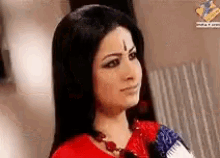

So basically we tried to introduce new data so our model will generalize more. A way to overcome the problem of limited data.

Min Jun Park also describe it nicely on our 1st Townhall about data augmentation advantage and it's risk.

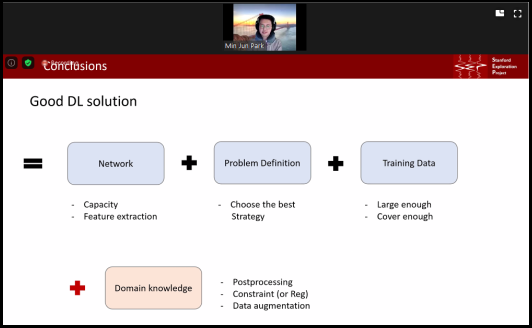

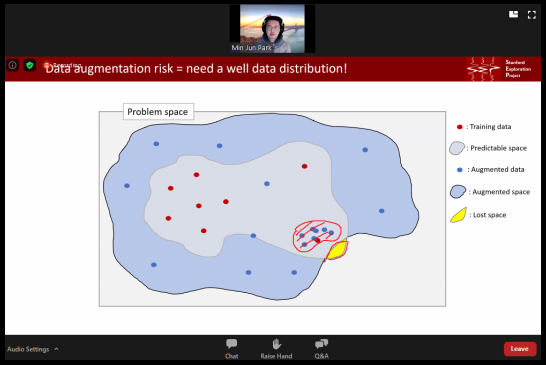

and now let's set up the test loader dataset:

In [ ]:
class seisdataset_test(Dataset):
    def __init__(self, x_set, y_set):
        self.x, self.y = x_set, y_set
        self.n_sample = self.x.shape[1]
        self.aug2 = A.Compose([
            A.Resize(p=1, height=640, width=320, interpolation=0)
        ])  

    def __len__(self):
        return self.n_sample
    
    def __getitem__(self, index):
        batch_x = self.x[:,index,:]
        batch_y = self.y[:,index,:]-1
        augmented = self.aug2(image=batch_x, mask=batch_y)
        image, mask = augmented['image'], augmented['mask']
        return image[None,:,:], mask

Let's test the data loader if it can fetch anything :

In [ ]:
train_dataset = seisdataset_train(train_data, train_label)

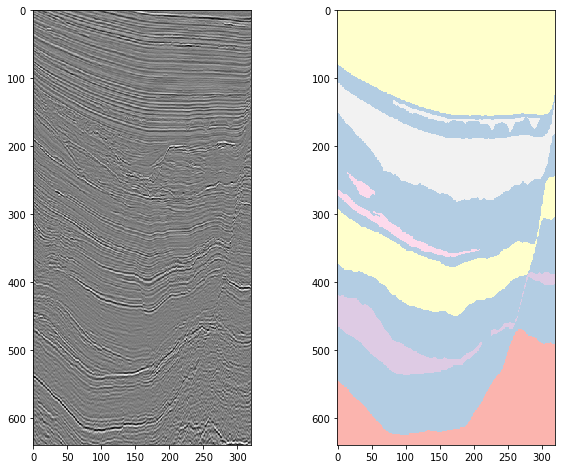

In [ ]:
random_id = np.random.randint(0,len(train_dataset))
data_pick = train_dataset[random_id]
img = data_pick[0][0,:,:]
lbl = data_pick[1]
fig, ax = plt.subplots(1, 2, figsize=(10,8))
ax[0].imshow(img,interpolation='none',cmap='gray')
ax[1].imshow(lbl,interpolation='none',cmap='Pastel1')
plt.show()

Let's put it into a loader:

In [ ]:
def get_data_loaders(batch_size):
    train_dataset = seisdataset_train(train_data, train_label)
    test_dataset = seisdataset_test(test_data, test_label)
    
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

In [ ]:
train_loader,test_loader=get_data_loaders(batch_size)

Now put some variable for the training log :

In [ ]:
train_losses = []
valid_losses = []
train_F1 = []
test_F1 = []
test_F1_uw = []
train_acc = []
test_acc = []
F1_old = 0.0
F1uw_old = 0.0

#Training

... and now train the model!

It's gonna take some times. Better go watch some youtube video.

See you in half an hour-ish!

In [ ]:
for epoch in range(1, num_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    F1_train = 0.0
    acc_train = 0.0
    F1_test = 0.0
    F1uw_test = 0.0
    acc_test = 0.0    
    model.train()
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        acc = accuracy_score(label.cpu().numpy().flatten()+1, pred.flatten()+1)
        f1s, f1uw = compute_scores(label.cpu().numpy().flatten()+1, pred.flatten()+1)   
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        F1_train += f1s
        acc_train += acc
    model.eval()
    for data, label in test_loader:        
        data = data.to(device)
        label = label.to(device)
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        acc = accuracy_score(label.cpu().numpy().flatten()+1, pred.flatten()+1)
        f1s, f1uw = compute_scores(label.cpu().numpy().flatten()+1, pred.flatten()+1)  
        valid_loss += loss.item() * data.size(0)
        F1_test += f1s
        F1uw_test += f1uw
        acc_test += acc

    train_loss = train_loss/len(train_loader.sampler)
    F1_train = F1_train/len(train_loader.sampler)*batch_size
    acc_train = acc_train/len(train_loader.sampler)*batch_size    
    valid_loss = valid_loss/len(test_loader.sampler)*batch_size
    F1_test = F1_test/len(test_loader.sampler)*batch_size
    F1uw_test = F1uw_test /len(test_loader.sampler)*batch_size
    acc_test = acc_test/len(test_loader.sampler)*batch_size
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_F1.append(F1_train)
    test_F1.append(F1_test)
    test_F1_uw.append(F1uw_test)
    train_acc.append(acc_train)
    test_acc.append(acc_test)      

    if F1_old < F1_test:
      F1_old = F1_test
      torch.save(model.state_dict(), 'modelbestf1_weighted_run1.ckpt')
    if F1uw_old < F1uw_test:
      F1uw_old = F1uw_test
      torch.save(model.state_dict(), 'modelbestf1_unweighted_run1.ckpt')  

    # print
    print('Epoch: {} \tTrain Loss: {:.3f} \tVal. Loss: {:.3f} \tF1_train: {:.3f} \tF1_test: {:.3f} \tF1u_test: {:.3f}'.format(
        epoch, train_loss, valid_loss, F1_train, F1_test, F1uw_test))

Epoch: 1 	Train Loss: 0.492 	Val. Loss: 23.184 	F1_train: 0.533 	F1_test: 0.043 	F1u_test: 0.054
Epoch: 2 	Train Loss: 0.207 	Val. Loss: 48.560 	F1_train: 0.752 	F1_test: 0.076 	F1u_test: 0.184
Epoch: 3 	Train Loss: 0.161 	Val. Loss: 9.070 	F1_train: 0.804 	F1_test: 0.328 	F1u_test: 0.447
Epoch: 4 	Train Loss: 0.132 	Val. Loss: 6.158 	F1_train: 0.835 	F1_test: 0.337 	F1u_test: 0.500
Epoch: 5 	Train Loss: 0.124 	Val. Loss: 2.940 	F1_train: 0.847 	F1_test: 0.446 	F1u_test: 0.651
Epoch: 6 	Train Loss: 0.107 	Val. Loss: 2.990 	F1_train: 0.863 	F1_test: 0.490 	F1u_test: 0.676
Epoch: 7 	Train Loss: 0.102 	Val. Loss: 2.228 	F1_train: 0.868 	F1_test: 0.575 	F1u_test: 0.740
Epoch: 8 	Train Loss: 0.097 	Val. Loss: 2.047 	F1_train: 0.876 	F1_test: 0.580 	F1u_test: 0.753
Epoch: 9 	Train Loss: 0.090 	Val. Loss: 1.442 	F1_train: 0.881 	F1_test: 0.632 	F1u_test: 0.803
Epoch: 10 	Train Loss: 0.085 	Val. Loss: 1.792 	F1_train: 0.885 	F1_test: 0.613 	F1u_test: 0.781
Epoch: 11 	Train Loss: 0.084 	Val. Lo

#Performance

Let's see the training performance :

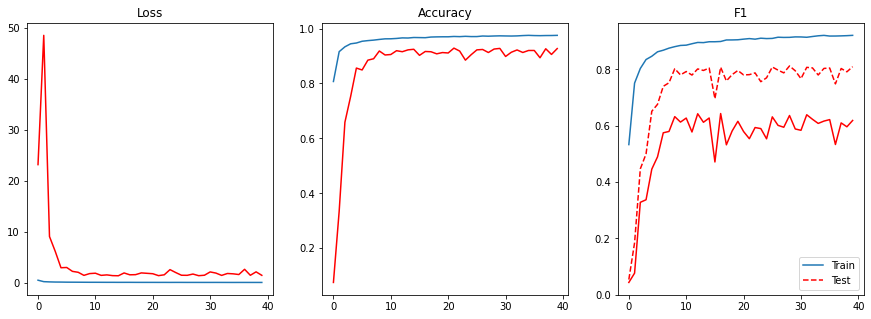

In [ ]:
fig2, ax = plt.subplots(1,3,  figsize=(15,5))
ax[0].plot(train_losses)
ax[1].plot(train_acc)
ax[2].plot(train_F1)
ax[0].plot(valid_losses,'-r')
ax[1].plot(test_acc,'-r')
ax[2].plot(test_F1_uw,'--r')
ax[2].plot(test_F1,'-r')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[2].set_title('F1')
ax[2].legend(("Train", "Test"))
plt.show()

---
Now let's see our best score.

In [ ]:
print("Best F1            :",F1_old)
print("Best F1 unweighted :",F1uw_old)

Best F1            : 0.6433850880601024
Best F1 unweighted : 0.81251770782969


---

So, that's it.

It's certainly not the best, if it is, I'd get some money by now. (Still won a drone, though. Thanks Aicrowd and SEAM AI!)

But I hope, you can learn new stuff and at least not getting error when submitting to this challenge.

If you guys got any question, just comment on my submission here. 
also please hit that love button! (Me want cool VR gear)

Thanks and see ya!



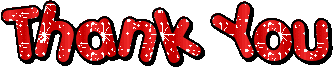

---

---


#Credits

Image and glitter text (pretty important) from :

- wikipedia

- cem.utexas.edu

- https://en.bloggif.com/

Music :

- Benjamin Tissot - Jazzy Frenchie www.bensound.com
- Benjamin Tissot - The Elevator Bossa www.bensound.com 

Some packages :

- Yakubovskiy, 2019. Segmentation Models Pytorch}, https://github.com/qubvel/segmentation_models.pytorch

- Buslaev, A.; Iglovikov, V.I.; Khvedchenya, E.; Parinov, A.; Druzhinin, M.; Kalinin, A.A. Albumentations: Fast and Flexible Image Augmentations. Information 2020, 11, 125. https://doi.org/10.3390/info11020125 https://github.com/albumentations-team/albumentations

#Making a Submission

Download the test data:

In [ ]:
!gdown "https://drive.google.com/uc?id=1-GZiUbyzmTK-nR9AZC9t1Q8ZF2iC3sH1"

Downloading...
From: https://drive.google.com/uc?id=1-GZiUbyzmTK-nR9AZC9t1Q8ZF2iC3sH1
To: /content/data_test_2.npz
1.04GB [00:10, 103MB/s]


Read it :

In [ ]:
test2_data = np.load('data_test_2.npz')['data']

In [ ]:
test2_data.shape

(1006, 334, 841)

Preprocess the data :

In [ ]:
from ipywidgets import IntProgress
from IPython.display import display
import time
print('preprocessing the data :')
f = IntProgress(min=0, max=test2_data.shape[1])
display(f)
for i in range(0,test2_data.shape[1]):
    #print('reprocess : ',i+1,'of',train_data_full.shape[1])
    test2_data[:,i,:]=gain(test2_data[:,i,:],3e-3,0.8)
    f.value += 1

preprocessing the data :


IntProgress(value=0, max=334)

In [ ]:
test2_data = (test2_data - test2_data.min()) / (test2_data.max() - test2_data.min())

Load the best score model :

In [ ]:
model.load_state_dict(torch.load('modelbestf1_unweighted_run1.ckpt'))

<All keys matched successfully>

Predict it :

In [ ]:
pred=np.zeros([1006,334,841],dtype='int32')
model.eval()
for i in range(334):
    print('predicting...',i+1,'of','334')
    tempcek=test2_data[:,i,:]

    temp=cv2.resize(tempcek, (320,640), interpolation=cv2.INTER_NEAREST)
    
    temp=temp[None,None,:,:]
    #temp=temp.cuda()
    score = model(torch.from_numpy(temp).float().cuda())
    temppred = score.max(1)[1].cpu().numpy()[0, :, :]+1    
    
    temppred=cv2.resize(temppred, (841,1006), interpolation=cv2.INTER_NEAREST)

    pred[:,i,:]=temppred

predicting... 1 of 334
predicting... 2 of 334
predicting... 3 of 334
predicting... 4 of 334
predicting... 5 of 334
predicting... 6 of 334
predicting... 7 of 334
predicting... 8 of 334
predicting... 9 of 334
predicting... 10 of 334
predicting... 11 of 334
predicting... 12 of 334
predicting... 13 of 334
predicting... 14 of 334
predicting... 15 of 334
predicting... 16 of 334
predicting... 17 of 334
predicting... 18 of 334
predicting... 19 of 334
predicting... 20 of 334
predicting... 21 of 334
predicting... 22 of 334
predicting... 23 of 334
predicting... 24 of 334
predicting... 25 of 334
predicting... 26 of 334
predicting... 27 of 334
predicting... 28 of 334
predicting... 29 of 334
predicting... 30 of 334
predicting... 31 of 334
predicting... 32 of 334
predicting... 33 of 334
predicting... 34 of 334
predicting... 35 of 334
predicting... 36 of 334
predicting... 37 of 334
predicting... 38 of 334
predicting... 39 of 334
predicting... 40 of 334
predicting... 41 of 334
predicting... 42 of 334
p

See sample result :

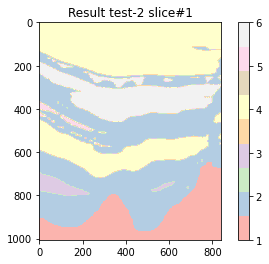

In [ ]:
plt.imshow(pred[:,1,:],cmap='Pastel1')
plt.title('Result test-2 slice#1')
plt.colorbar()
plt.show()

In [ ]:
np.savez_compressed('submission_pspnet_run1.npz',prediction=pred)

---



In [ ]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

#Worth to Try

What we did above is just a simple tile predict. You can use pytorch-toolbelt just like **ivan_romanov** explainer.

or..

use this https://github.com/the-lay/tiler which based on this interesting paper  :

[Introducing Hann windows for reducing edge-effects in patch-based image segmentation](https://doi.org/10.1371/journal.pone.0229839), Pielawski and Wählby, March 2020